# ISYE-6740 - Group Project - CNN On PCA Data

__Objective:__ It looks like Maninder built a CNN using keras on the raw image file, and got surprisingly low results. What if we applied it directly to the PCA data?

## Import Packages and Data

In [1]:
# packages

## general use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## modeling
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib

In [2]:
# import data and slice it
xrays = pd.read_csv('Pnuemonia Images PCA Reduced.csv')\
    .drop('Unnamed: 0', axis = 1)

## map labels to numbers
y_map = {'normal': 0, 'bacteria': 1, 'virus': 2}
xrays['label'] = xrays['y'].map(y_map)

## slice out feature data
X_train = xrays[xrays['set'] == 'train'].drop(['y', 'set'], axis = 1).to_numpy()
X_test = xrays[xrays['set'] == 'test'].drop(['y', 'set'], axis = 1).to_numpy()
X_val = xrays[xrays['set'] == 'validate'].drop(['y', 'set'], axis = 1).to_numpy()

## slice out labels
y_train = xrays[xrays['set'] == 'train'].label.to_numpy()
y_test = xrays[xrays['set'] == 'test'].label.to_numpy()
y_val = xrays[xrays['set'] == 'validate'].label.to_numpy()

## General Use Functions

In [3]:
#function to plot the confusion matrix for each model
def plot_cm(predictions, y_test, title):
    # confusion matrix
    labels = ['Normal', 'Bacteria', 'Virus']
    cm = confusion_matrix(y_test,predictions)
    cm = pd.DataFrame(cm , index = ['0','1','2'] , columns = ['0','1','2'])
    
    # plot
    fig = plt.figure(figsize = (7,7))
    fig = plt.title(title)
    fig = sns.set(font_scale = 2)
    fig = sns.heatmap(cm, linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)
    fig.set(xlabel = 'True', ylabel = "Prediction")
    plt.savefig('cnn_on_pca/' + title + '.png')
    plt.show()

In [4]:
def classification_report_csv(report, title):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dum = lines[6].split('      ')
    row1 = {}
    row1['class'] = dum[0]
    row1['precision'] = ''
    row1['recall'] = ''
    row1['f1_score'] = float(dum[4])
    row1['support'] = float(dum[5])
    report_data.append(row1)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv('cnn_on_pca/'+title+'.csv', index = False)

## Baseline Performance

In [5]:
mod_base = MLPClassifier(verbose = False).fit(X_train, y_train)

In [6]:
mod_base_pred = mod_base.predict(X_test)

In [7]:
mod_base_acc = mod_base.score(X_test, y_test)
print('Baseline Model Accuracy = {}%'.format(round(100 * mod_base_acc, 2)))

Baseline Model Accuracy = 99.89%


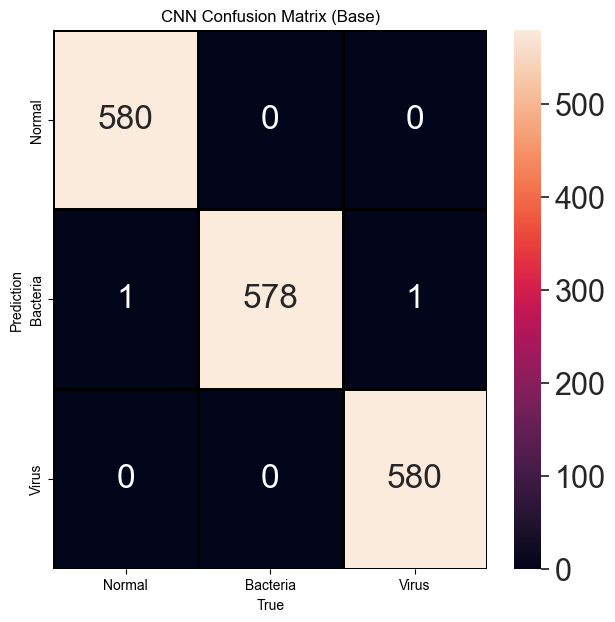

In [8]:
# print(confusion_matrix(y_test, mod_base_pred))
plot_cm(mod_base_pred, y_test, 'CNN Confusion Matrix (Base)')

In [9]:
base_cnn_report = classification_report(y_test, mod_base_pred)
classification_report_csv(base_cnn_report, 'CNN Classification Report (Base)')
print(base_cnn_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       580
           1       1.00      1.00      1.00       580
           2       1.00      1.00      1.00       580

    accuracy                           1.00      1740
   macro avg       1.00      1.00      1.00      1740
weighted avg       1.00      1.00      1.00      1740



## Model Tuning

In [10]:
# hyperparameter tuning

## define model and params to evaluate
mod = MLPClassifier(random_state = 20230730)
params = {
    'hidden_layer_sizes': [(100, ), (100, 100), (200, 200)],
    'activation': ['tanh', 'relu']
}

## define parameter grid
grid_mlp = GridSearchCV(
    mod,
    params,
    cv = 10,
    scoring = 'accuracy',
    return_train_score = True,
    verbose = 1
)
grid_mlp = grid_mlp.fit(X_train, y_train)

print(grid_mlp.best_params_)
grid_mlp_acc = grid_mlp.best_score_ * 100
print('Accuracy of Tuned MLP Model = {}%'.format(round(grid_mlp_acc, 2)))

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'activation': 'tanh', 'hidden_layer_sizes': (100,)}
Accuracy of Tuned MLP Model = 99.8%


In [11]:
# fit model with best params
mod_tuned = MLPClassifier(
    hidden_layer_sizes = grid_mlp.best_params_['hidden_layer_sizes'],
    activation = grid_mlp.best_params_['activation'],
    random_state = 20230730
).fit(X_train, y_train)

mod_tuned_pred = mod_tuned.predict(X_test)
mod_tuned_acc = mod_tuned.score(X_test, y_test)
print('Baseline Model Accuracy = {}%'.format(round(100 * mod_tuned_acc, 4)))

Baseline Model Accuracy = 100.0%


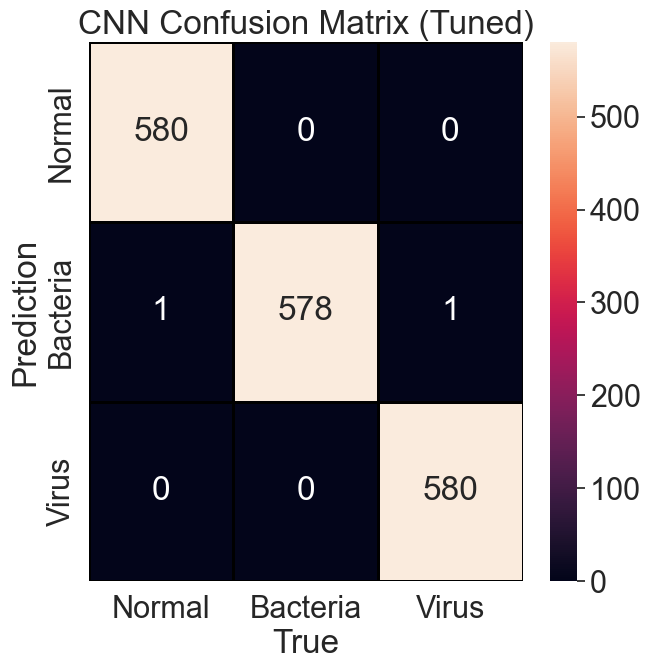

In [12]:
# print(confusion_matrix(y_test, mod_base_pred))
plot_cm(mod_base_pred, y_test, 'CNN Confusion Matrix (Tuned)')

In [13]:
tuned_cnn_report = classification_report(y_test, mod_tuned_pred)
classification_report_csv(tuned_cnn_report, 'CNN Classification Report (Tuned)')
print(tuned_cnn_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       580
           1       1.00      1.00      1.00       580
           2       1.00      1.00      1.00       580

    accuracy                           1.00      1740
   macro avg       1.00      1.00      1.00      1740
weighted avg       1.00      1.00      1.00      1740



## Save Models

In [14]:
joblib.dump(mod_base, 'cnn_on_pca/CNN Model (Base).sav')
joblib.dump(mod_tuned, 'cnn_on_pca/CNN Model (Tuned).sav')

['cnn_on_pca/CNN Model (Tuned).sav']